In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install dask-ml --quiet
!pip install dask --quiet
!pip install kmodes --quiet
!pip install gower --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 5.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df_init = pd.read_csv('/content/drive/MyDrive/df_base.csv', low_memory = False)
#df_init['fecha_suceso'] = pd.to_datetime(df_init['fecha_suceso'])
iter_csv = pd.read_csv('/content/drive/MyDrive/df_base.csv', iterator=True, chunksize=1000)
df = pd.concat([chunk[ pd.to_datetime(chunk['fecha_suceso']).dt.year  >= 2016] for chunk in iter_csv])
pd.set_option('display.max_columns', None)
df.head()

,num_denuncia,fecha_suceso,hora_suceso,direccion_suceso,fecha_denuncia,delito_completado_interrumpido,nivel_ofensa,distrito,jurisdiccion_encargada,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,geoespacial,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,diff_dias_hecho_denuncia,dia_suceso,estacion_suceso,mes_suceso
0,506547392,2018-03-29,Noche,32.0,2018-03-30,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,UNKNOWN,UNKNOWN,Desconocido,"(40.810877241, -73.941064151)",25-44,WHITE,Femenino,incidentes_menores,lugares solitarios,1,jueves,primavera,abril
1,629632833,2018-02-06,Noche,52.0,2018-02-07,COMPLETED,MISDEMEANOR,BRONX,Policia,45-64,BLACK,Femenino,"(40.873671035, -73.908013649)",UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,1,martes,invierno,marzo
2,787203902,2018-11-21,Madrugada,75.0,2018-11-21,COMPLETED,MISDEMEANOR,BROOKLYN,Policia,25-44,WHITE,Femenino,"(40.651782232, -73.885456761)",UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares publicos,0,miercoles,otono,diciembre
3,280364018,2018-06-09,Noche,10.0,2018-06-10,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,25-44,WHITE,Masculino,"(40.759310399, -73.994706072)",UNKNOWN,WHITE,Femenino,incidentes_menores,lugares publicos,1,sabado,verano,julio
4,985800320,2018-11-10,Noche,19.0,2018-11-10,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,<18,BLACK,Femenino,"(40.764535539, -73.970728388)",UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,0,sabado,otono,diciembre


Acotaremos el ejercicio a los distritos donde más casos hubieron

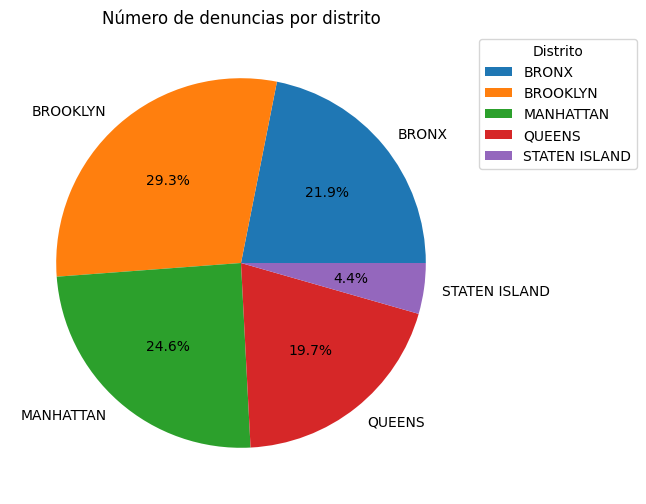

In [ ]:
distritos_counts = df.groupby(['distrito']).size()

# Crear un gráfico de torta
plt.figure(figsize=(6, 6))
distritos_counts.plot.pie(autopct='%1.1f%%')
plt.title('Número de denuncias por distrito')
plt.legend(title='Distrito', labels=distritos_counts.index, bbox_to_anchor=(1, 1))
plt.show()

## BROOKLYN

In [ ]:
df_brooklyn = df[df.distrito == 'BROOKLYN'].copy()
df_brooklyn.reset_index(inplace = True, drop = True)
df_brooklyn['direccion_suceso'] = df_brooklyn['direccion_suceso'].astype('object')

In [ ]:
df_brooklyn.drop(columns= ['fecha_suceso', 'fecha_denuncia', 'num_denuncia', 'direccion_suceso', 'distrito', 'diff_dias_hecho_denuncia', 'nivel_ofensa','delito_completado_interrumpido'], inplace = True)

Separamos coordenadas

In [ ]:
df_brooklyn['latitud'] = df_brooklyn.geoespacial.apply(lambda x: float(x.replace('(', '').replace(')', '').split(',')[0]))
df_brooklyn['longitud'] = df_brooklyn.geoespacial.apply(lambda x: float(x.replace('(', '').replace(')', '').split(',')[1]))
df_brooklyn.drop(columns= ['geoespacial'], inplace = True)
df_brooklyn.head()

,hora_suceso,jurisdiccion_encargada,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso,latitud,longitud
0,Madrugada,Policia,25-44,WHITE,Femenino,UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares publicos,miercoles,otono,diciembre,40.651782,-73.885457
1,Tarde,Policia,UNKNOWN,BLACK,Desconocido,<18,BLACK,Masculino,delitos_graves,lugares publicos,martes,invierno,febrero,40.635516,-73.913278
2,Noche,Policia,UNKNOWN,UNKNOWN,Desconocido,UNKNOWN,UNKNOWN,Transgenero,incidentes_menores,lugares publicos,miercoles,otono,diciembre,40.671535,-73.961948
3,Tarde,Policia,UNKNOWN,WHITE,Femenino,25-44,WHITE,Masculino,incidentes_menores,lugares publicos,martes,verano,agosto,40.579353,-73.980497
4,Madrugada,Policia,UNKNOWN,ASIAN / PACIFIC ISLANDER,Masculino,UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares solitarios,domingo,invierno,febrero,40.610565,-74.010396


In [ ]:
from sklearn.preprocessing import MinMaxScaler
num_cols = df_brooklyn.select_dtypes('number')
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(num_cols), columns = num_cols.columns.tolist())
df_brooklyn_ready = pd.concat([df_brooklyn.drop(columns = num_cols.columns.tolist()), scaled], axis = 1)
df_brooklyn_ready_sample = df_brooklyn_ready.sample(frac = 0.05, replace = True, random_state=1234)

## **1ra iteración:** de 2016 a 2019
- Sin reducción de de dimensionalidad y aplicación de KMeans y, adicional, con reducción de dimensionalidad aplicando KMeans.

## **2da iteración:** De 2016 a 2019 y distrito con mayor número de casos
- Sin reducción de dimensionalidad y KModes.

### 1.1 Sin reducción de dimensionalidad y aplicación de KMeans.

Método del codo

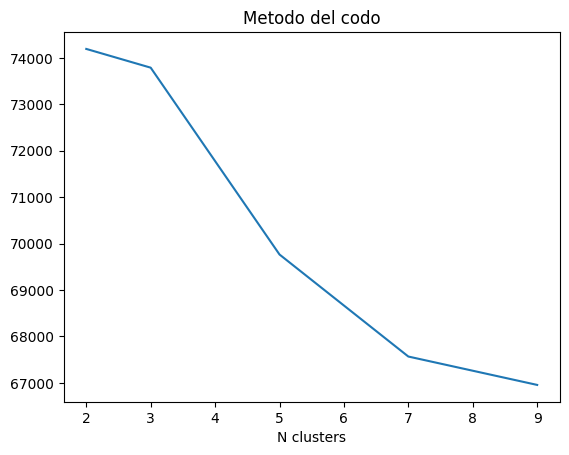

In [ ]:
from sklearn.metrics import silhouette_score  
from dask_ml.cluster import KMeans as KMeansDask
import dask.dataframe as da

# crear matriz Dask
sample = df_brooklyn_ready_sample.copy()
dummies = pd.get_dummies(sample)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
n_clusters = [2,3,5,7,9]
km = []
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(X)
  km.append(kmeans.inertia_)

plt.title('Metodo del codo')
plt.xlabel('N clusters')
plt.plot(n_clusters, km)
plt.show()


In [ ]:
from sklearn import metrics
sample = df_brooklyn_ready_sample.copy()
dummies = pd.get_dummies(sample)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
n_clusters = [2,3,5,7,9]
km = []
metrics_df_general = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(X) 
  labels = kmeans.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(X, labels)
  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(X, labels)
  metrics_df = pd.DataFrame({'Metodo': ['KMeans'],
                           'k':[k],
                           'Calinski-Harabasz Index': [ch_score],
                           'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general = metrics_df_general.append(metrics_df, ignore_index=True)
metrics_df_general

,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KMeans,2,3214.809666,0.101131
1,KMeans,3,2627.229091,0.103900
2,KMeans,5,1961.062258,0.087516
3,KMeans,7,1368.699842,0.075553
4,KMeans,9,1249.444090,0.064177


### Centroides con KMeans y clusters igual a 3

In [ ]:
from dask_ml.cluster import KMeans as KMeansDask
import dask.dataframe as da

# crear matriz Dask
dummies = pd.get_dummies(df_brooklyn_ready)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
kmeans = KMeansDask(n_clusters=3, random_state=1234)
kmeans.fit(X)
centroids = kmeans.cluster_centers_ 
labels = kmeans.labels_ 


In [ ]:
centroides_brooklyn = pd.DataFrame(centroids, columns = pd.get_dummies(df_brooklyn_ready_sample).columns.tolist())
centroides_brooklyn.reset_index(inplace = True, drop = False)
centroides_brooklyn.rename(columns = {'index':'cluster'}, inplace =True)
centroides_brooklyn

,cluster,latitud,longitud,hora_suceso_Madrugada,hora_suceso_Mañana,hora_suceso_Noche,hora_suceso_Tarde,jurisdiccion_encargada_Externas,jurisdiccion_encargada_Otras,jurisdiccion_encargada_Policia,jurisdiccion_encargada_Transito,jurisdiccion_encargada_Vivienda,grupo_edad_sospechoso_25-44,grupo_edad_sospechoso_45-64,grupo_edad_sospechoso_<18,grupo_edad_sospechoso_UNKNOWN,raza_sospechoso_AMERICAN INDIAN/ALASKAN NATIVE,raza_sospechoso_ASIAN / PACIFIC ISLANDER,raza_sospechoso_BLACK,raza_sospechoso_UNKNOWN,raza_sospechoso_WHITE,sexo_sospechoso_Desconocido,sexo_sospechoso_Femenino,sexo_sospechoso_Masculino,grupo_edad_victima_25-44,grupo_edad_victima_45-64,grupo_edad_victima_<18,grupo_edad_victima_UNKNOWN,raza_victima_AMERICAN INDIAN/ALASKAN NATIVE,raza_victima_ASIAN / PACIFIC ISLANDER,raza_victima_BLACK,raza_victima_UNKNOWN,raza_victima_WHITE,sexo_victima_Femenino,sexo_victima_Masculino,sexo_victima_Transgenero,tipo_crimen_armas_drogas,tipo_crimen_crimenes_sexuales,tipo_crimen_delitos_graves,tipo_crimen_extorsion,tipo_crimen_incidentes_menores,tipo_crimen_otros_crimenes,lugar_Otros,lugar_diversion y turismo,lugar_lugares publicos,lugar_lugares solitarios,lugar_necesidades diarias,dia_suceso_domingo,dia_suceso_jueves,dia_suceso_lunes,dia_suceso_martes,dia_suceso_miercoles,dia_suceso_sabado,dia_suceso_viernes,estacion_suceso_invierno,estacion_suceso_otono,estacion_suceso_primavera,estacion_suceso_verano,mes_suceso_abril,mes_suceso_agosto,mes_suceso_diciembre,mes_suceso_febrero,mes_suceso_julio,mes_suceso_junio,mes_suceso_marzo,mes_suceso_mayo,mes_suceso_noviembre,mes_suceso_octubre,mes_suceso_septiembre
0,0,0.274280,0.504826,0.169556,0.205539,0.302244,0.322661,0.000120,0.007869,0.913715,0.018066,0.060230,0.001385,0.000731,0.000748,0.997136,0.000158,0.001192,0.010322,0.984289,0.004039,0.941847,0.019626,0.038526,0.367342,0.205214,0.035154,0.392290,0.005663,0.067902,0.318814,0.280314,0.327307,0.347955,0.423371,0.228675,0.036047,0.071693,0.071334,0.560115,0.242621,0.018190,0.037539,0.126243,0.750049,0.038501,0.047669,0.127602,0.144920,0.141958,0.143527,0.145587,0.137928,0.158478,0.232137,0.255917,0.243232,0.268714,0.078737,0.091606,0.161388,0.082250,0.086665,0.086490,0.069876,0.078006,0.086934,0.087605,0.090443
1,1,0.244530,0.465559,0.179764,0.182378,0.308519,0.329340,0.000046,0.005861,0.921822,0.016997,0.055274,0.460315,0.171178,0.038286,0.330221,0.007466,0.087029,0.000000,0.053026,0.852478,0.011658,0.209152,0.779189,0.354721,0.170252,0.048000,0.427028,0.006017,0.079086,0.093707,0.309307,0.511883,0.418828,0.315004,0.266169,0.082920,0.251585,0.213922,0.214133,0.179387,0.058053,0.026756,0.150320,0.749213,0.033645,0.040066,0.144082,0.144064,0.131626,0.138203,0.143826,0.150338,0.147861,0.232341,0.249172,0.257189,0.261298,0.084433,0.086754,0.154099,0.080801,0.086139,0.088653,0.075738,0.084103,0.086451,0.084424,0.088405
2,2,0.285604,0.530877,0.154229,0.199822,0.309194,0.336756,0.000040,0.008126,0.830492,0.028042,0.133300,0.418607,0.146985,0.059358,0.375050,0.000852,0.005058,0.975121,0.018969,0.000000,0.016533,0.242221,0.741246,0.351268,0.172330,0.059990,0.416411,0.003163,0.031887,0.549370,0.283713,0.131866,0.466320,0.286275,0.247405,0.063053,0.239840,0.237464,0.250242,0.154570,0.054832,0.031837,0.139405,0.740990,0.031015,0.056752,0.135290,0.142268,0.138999,0.143772,0.148333,0.142659,0.148679,0.229939,0.251244,0.249420,0.269396,0.080608,0.091492,0.155041,0.080558,0.086885,0.089080,0.072663,0.079731,0.086534,0.086388,0.091020


In [ ]:
brooklyn_kmeans_sin_reduccion = df_brooklyn_ready.copy()
brooklyn_kmeans_sin_reduccion['clusters'] = kmeans.labels_

### Análisis de clusters en KMeans sin reducción

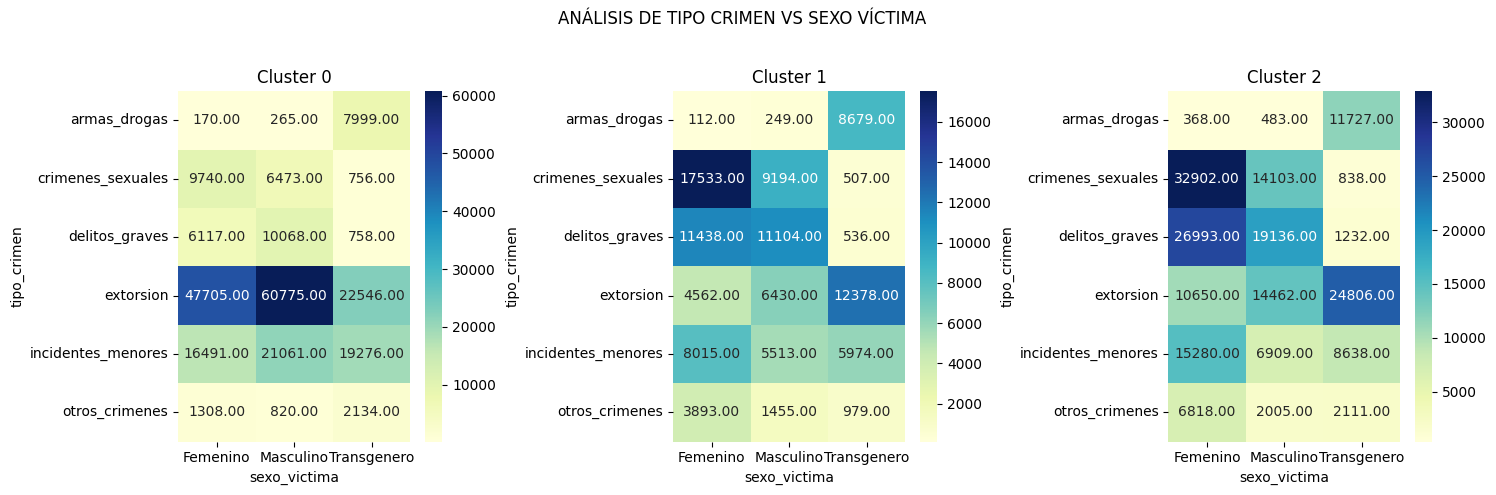

In [ ]:
brooklyn_cluster0 = brooklyn_kmeans_sin_reduccion[brooklyn_kmeans_sin_reduccion['clusters']==0]
brooklyn_cluster1 = brooklyn_kmeans_sin_reduccion[brooklyn_kmeans_sin_reduccion['clusters']==1]
brooklyn_cluster2 = brooklyn_kmeans_sin_reduccion[brooklyn_kmeans_sin_reduccion['clusters']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(brooklyn_cluster0['tipo_crimen'], brooklyn_cluster0['sexo_victima'])
ct1 = pd.crosstab(brooklyn_cluster1['tipo_crimen'], brooklyn_cluster1['sexo_victima'])
ct2 = pd.crosstab(brooklyn_cluster2['tipo_crimen'], brooklyn_cluster2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

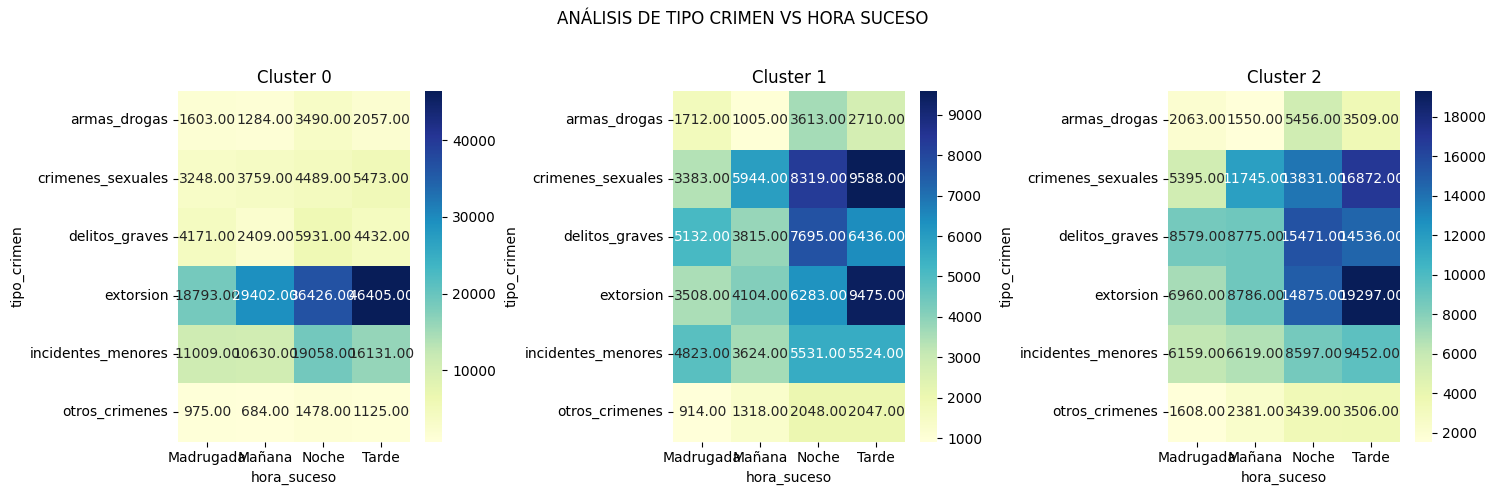

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(brooklyn_cluster0['tipo_crimen'], brooklyn_cluster0['hora_suceso'])
ct1 = pd.crosstab(brooklyn_cluster1['tipo_crimen'], brooklyn_cluster1['hora_suceso'])
ct2 = pd.crosstab(brooklyn_cluster2['tipo_crimen'], brooklyn_cluster2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

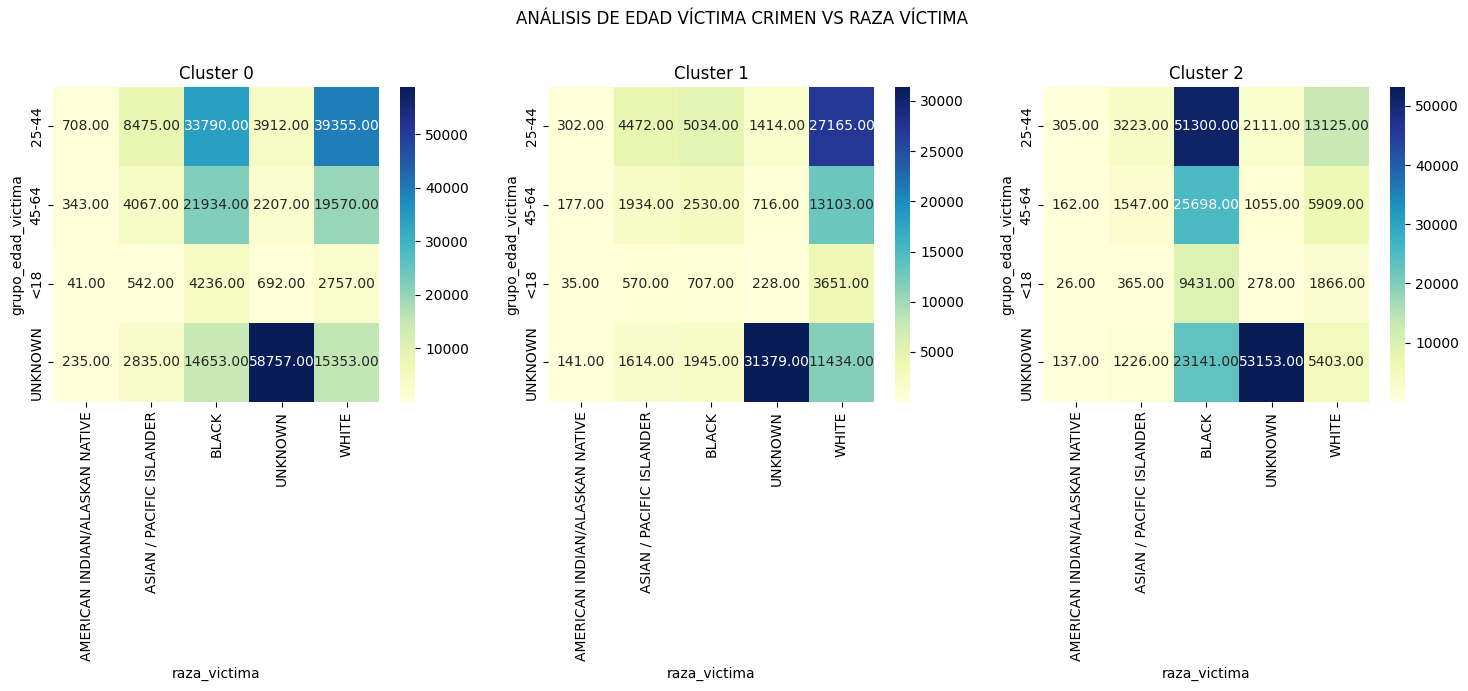

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(brooklyn_cluster0['grupo_edad_victima'], brooklyn_cluster0['raza_victima'])
ct1 = pd.crosstab(brooklyn_cluster1['grupo_edad_victima'], brooklyn_cluster1['raza_victima'])
ct2 = pd.crosstab(brooklyn_cluster2['grupo_edad_victima'], brooklyn_cluster2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

In [ ]:
for column in brooklyn_kmeans_sin_reduccion.columns:
  if column not in ['clusters', 'latitud', 'longitud']:
    print(f"Variable {column}:")
    aux1 = brooklyn_kmeans_sin_reduccion.groupby(['clusters', column]).size().reset_index().rename(columns = {0:'casos'})
    aux2 = brooklyn_kmeans_sin_reduccion.groupby('clusters').size().reset_index().rename(columns = {0:'casos_totales'})
    aux3 = aux1.merge(aux2,how='left', on = 'clusters')
    aux3['participacion'] = aux3['casos']/aux3['casos_totales']
    aux3.drop(columns = ['casos_totales'], inplace = True)
    pd.options.display.float_format = '{:.1%}'.format 
    display(aux3)
    print('\n')
  pd.reset_option('display.float_format')

Variable hora_suceso:


,clusters,hora_suceso,casos,participacion
0,0,Madrugada,39799,17.0%
1,0,Mañana,48168,20.5%
2,0,Noche,70872,30.2%
3,0,Tarde,75623,32.3%
4,1,Madrugada,19472,17.9%
5,1,Mañana,19810,18.2%
6,1,Noche,33489,30.9%
7,1,Tarde,35780,33.0%
8,2,Madrugada,30764,15.4%
9,2,Mañana,39856,20.0%




Variable jurisdiccion_encargada:


,clusters,jurisdiccion_encargada,casos,participacion
0,0,Externas,28,0.0%
1,0,Otras,1841,0.8%
2,0,Policia,214239,91.4%
3,0,Transito,4240,1.8%
4,0,Vivienda,14114,6.0%
5,1,Externas,5,0.0%
6,1,Otras,639,0.6%
7,1,Policia,100049,92.2%
8,1,Transito,1843,1.7%
9,1,Vivienda,6015,5.5%




Variable grupo_edad_sospechoso:


,clusters,grupo_edad_sospechoso,casos,participacion
0,0,25-44,322,0.1%
1,0,45-64,173,0.1%
2,0,<18,181,0.1%
3,0,UNKNOWN,233786,99.7%
4,1,25-44,50186,46.2%
5,1,45-64,18660,17.2%
6,1,<18,4168,3.8%
7,1,UNKNOWN,35537,32.7%
8,2,25-44,83505,41.9%
9,2,45-64,29321,14.7%




Variable raza_sospechoso:


,clusters,raza_sospechoso,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,37,0.0%
1,0,ASIAN / PACIFIC ISLANDER,250,0.1%
2,0,BLACK,2417,1.0%
3,0,UNKNOWN,230819,98.4%
4,0,WHITE,939,0.4%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,816,0.8%
6,1,ASIAN / PACIFIC ISLANDER,9516,8.8%
7,1,UNKNOWN,5275,4.9%
8,1,WHITE,92944,85.6%
9,2,AMERICAN INDIAN/ALASKAN NATIVE,168,0.1%




Variable sexo_sospechoso:


,clusters,sexo_sospechoso,casos,participacion
0,0,Desconocido,220359,94.0%
1,0,Femenino,4565,1.9%
2,0,Masculino,9538,4.1%
3,1,Desconocido,1278,1.2%
4,1,Femenino,22830,21.0%
5,1,Masculino,84443,77.8%
6,2,Desconocido,3296,1.7%
7,2,Femenino,48318,24.2%
8,2,Masculino,147847,74.1%




Variable grupo_edad_victima:


,clusters,grupo_edad_victima,casos,participacion
0,0,25-44,86240,36.8%
1,0,45-64,48121,20.5%
2,0,<18,8268,3.5%
3,0,UNKNOWN,91833,39.2%
4,1,25-44,38387,35.4%
5,1,45-64,18460,17.0%
6,1,<18,5191,4.8%
7,1,UNKNOWN,46513,42.8%
8,2,25-44,70064,35.1%
9,2,45-64,34371,17.2%




Variable raza_victima:


,clusters,raza_victima,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,1327,0.6%
1,0,ASIAN / PACIFIC ISLANDER,15919,6.8%
2,0,BLACK,74613,31.8%
3,0,UNKNOWN,65568,28.0%
4,0,WHITE,77035,32.9%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,655,0.6%
6,1,ASIAN / PACIFIC ISLANDER,8590,7.9%
7,1,BLACK,10216,9.4%
8,1,UNKNOWN,33737,31.1%
9,1,WHITE,55353,51.0%




Variable sexo_victima:


,clusters,sexo_victima,casos,participacion
0,0,Femenino,81531,34.8%
1,0,Masculino,99462,42.4%
2,0,Transgenero,53469,22.8%
3,1,Femenino,45553,42.0%
4,1,Masculino,33945,31.3%
5,1,Transgenero,29053,26.8%
6,2,Femenino,93011,46.6%
7,2,Masculino,57098,28.6%
8,2,Transgenero,49352,24.7%




Variable tipo_crimen:


,clusters,tipo_crimen,casos,participacion
0,0,armas_drogas,8434,3.6%
1,0,crimenes_sexuales,16969,7.2%
2,0,delitos_graves,16943,7.2%
3,0,extorsion,131026,55.9%
4,0,incidentes_menores,56828,24.2%
5,0,otros_crimenes,4262,1.8%
6,1,armas_drogas,9040,8.3%
7,1,crimenes_sexuales,27234,25.1%
8,1,delitos_graves,23078,21.3%
9,1,extorsion,23370,21.5%




Variable lugar:


,clusters,lugar,casos,participacion
0,0,Otros,8797,3.8%
1,0,diversion y turismo,29569,12.6%
2,0,lugares publicos,175878,75.0%
3,0,lugares solitarios,9034,3.9%
4,0,necesidades diarias,11184,4.8%
5,1,Otros,2904,2.7%
6,1,diversion y turismo,16356,15.1%
7,1,lugares publicos,81309,74.9%
8,1,lugares solitarios,3642,3.4%
9,1,necesidades diarias,4340,4.0%




Variable dia_suceso:


,clusters,dia_suceso,casos,participacion
0,0,domingo,29931,12.8%
1,0,jueves,33973,14.5%
2,0,lunes,33282,14.2%
3,0,martes,33654,14.4%
4,0,miercoles,34124,14.6%
5,0,sabado,32358,13.8%
6,0,viernes,37140,15.8%
7,1,domingo,15636,14.4%
8,1,jueves,15645,14.4%
9,1,lunes,14286,13.2%




Variable estacion_suceso:


,clusters,estacion_suceso,casos,participacion
0,0,invierno,54431,23.2%
1,0,otono,59999,25.6%
2,0,primavera,57034,24.3%
3,0,verano,62998,26.9%
4,1,invierno,25215,23.2%
5,1,otono,27046,24.9%
6,1,primavera,27918,25.7%
7,1,verano,28372,26.1%
8,2,invierno,45866,23.0%
9,2,otono,50116,25.1%




Variable mes_suceso:


,clusters,mes_suceso,casos,participacion
0,0,abril,18468,7.9%
1,0,agosto,21470,9.2%
2,0,diciembre,37831,16.1%
3,0,febrero,19288,8.2%
4,0,julio,20323,8.7%
5,0,junio,20280,8.6%
6,0,marzo,16384,7.0%
7,0,mayo,18286,7.8%
8,0,noviembre,20387,8.7%
9,0,octubre,20540,8.8%


### 1.2.1 Con reducción de dimensionalidad y aplicación de KMeans.

In [ ]:
from dask_ml.decomposition import PCA

dummies = pd.get_dummies(df_brooklyn_ready_sample, dtype ='int')
# crear matriz Dask
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 

# crear objeto PCA
pca = PCA(n_components=X.shape[1])

# ajustar el modelo
pca.fit(X)

PCA(n_components=68)

In [ ]:
pca.explained_variance_ratio_[:40].sum(axis = 0)

0.973008467884551

In [ ]:
pca = PCA(n_components=40)
X_PCA =pca.fit_transform(X)
#X_PCA = X_PCA.compute() 

In [ ]:
X_PCA_ok = pd.DataFrame(X_PCA, columns = ['component'+str(column) for column in range(X_PCA.shape[1])])
X_PCA_ok.head()

,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,component10,component11,component12,component13,component14,component15,component16,component17,component18,component19,component20,component21,component22,component23,component24,component25,component26,component27,component28,component29,component30,component31,component32,component33,component34,component35,component36,component37,component38,component39
0,0.822363,-1.757504,-0.700292,-0.616529,0.332418,-0.068569,0.514200,0.810534,0.356379,0.112730,-1.049615,-0.339993,-0.222515,-0.575030,-0.498602,-0.488095,0.036525,-0.034322,0.081035,0.120126,-0.064139,-0.334860,0.199252,0.052162,0.017786,-0.780917,-0.754171,-0.305181,-0.116908,-0.409722,-0.224893,0.401434,0.271426,0.193756,-0.071789,-0.023351,-0.179573,0.103944,-0.018875,0.025475
1,0.699393,0.693288,-0.346880,-1.322265,-0.784570,0.144094,0.006515,-1.085033,0.108753,0.686710,-0.229226,-0.970582,-0.345085,-0.185057,0.580955,0.247051,-0.332504,0.284189,-0.803582,0.144004,-0.356060,-0.362857,0.179274,-0.559221,-0.163986,0.593337,-0.274669,-0.161183,0.027920,-0.011229,0.045734,0.083789,0.049129,0.138469,0.669671,-0.229874,-0.025957,0.001002,0.000661,-0.032134
2,-1.129683,-0.233586,0.496271,-0.187804,0.000678,-0.864469,-0.634811,0.251743,0.420469,-0.747084,-0.999138,-0.204014,-0.098548,-0.187772,-0.340336,0.177315,0.247223,-0.119962,0.114032,-0.923262,-0.083120,-0.036819,-0.171788,-0.125553,-0.466160,-0.223575,0.308765,-0.302392,0.020850,0.037785,-0.333007,-0.760570,0.391299,-0.179269,0.154653,0.124795,0.055100,0.193504,0.535459,-0.191525
3,-1.347135,0.666943,-0.943054,0.059448,0.071417,-0.007189,-1.141852,0.250872,0.726313,0.124490,0.421297,0.170547,-0.241155,0.166810,0.165340,0.161733,-0.086312,0.002325,0.025785,0.068108,-0.085614,-0.264467,0.012655,0.124843,0.237166,-0.784663,-0.244513,0.089203,-0.054822,0.103992,-0.442597,0.312667,-0.649120,0.043649,0.054795,0.084027,-0.006900,0.007370,-0.028018,-0.018591
4,-1.090840,0.598620,0.322783,0.677690,0.522982,-0.362689,-0.965337,-0.306032,-1.232913,-0.129389,0.136850,-0.302453,0.132895,-0.501806,-0.547989,0.402309,0.101933,-0.086323,0.087494,0.422438,0.601310,-0.160340,-0.222998,-0.419798,-0.034704,-0.015502,0.092683,-0.170950,-0.035289,0.023764,-0.267345,-0.555595,0.432499,0.348940,-0.000322,0.075318,0.030435,-0.000266,-0.041133,0.000208


Según el método del codo, cuántos cluster serían una elección óptima?

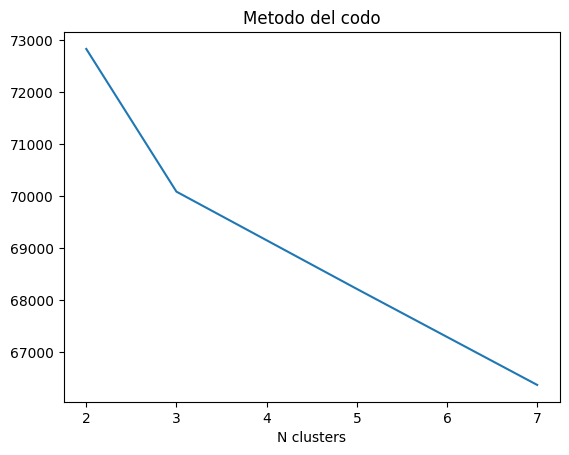

In [ ]:
n_clusters = [2, 3, 5, 7]

km = []

for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(X_PCA_ok)
  km.append(kmeans.inertia_)

plt.title('Metodo del codo')
plt.xlabel('N clusters')
plt.plot(n_clusters, km)
plt.show()

### Calinski-Harabasz Index y Silhouette Coefficient para n clusters en KMeans con PCA

In [ ]:
metrics_df_general_pca = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])
n_clusters = [2,3,5,7,9]
km = []
sample = X_PCA_ok.sample(frac=0.3)
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(sample) 
  labels = kmeans.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(sample, labels)

  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(sample, labels)

  metrics_df = pd.DataFrame({'Metodo': ['KMeans_PCA'],
                            'k':[k],
                            'Calinski-Harabasz Index': [ch_score],
                            'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general_pca = metrics_df_general_pca.append(metrics_df, ignore_index=True)

metrics_df_general_pca

,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KMeans_PCA,2,1008.025916,0.104982
1,KMeans_PCA,3,870.194329,0.110003
2,KMeans_PCA,5,605.064035,0.088051
3,KMeans_PCA,7,486.113974,0.077086
4,KMeans_PCA,9,397.554618,0.068022


### Centroides con KMeans y PCA y clusters igual a 3

In [ ]:
kmeans = KMeansDask(n_clusters=3, random_state = 1234)
kmeans.fit(X_PCA_ok)
centroids = kmeans.cluster_centers_ 
labels_pca = kmeans.labels_ 

In [ ]:
centroides_brooklyn_pca = pd.DataFrame(centroids, columns = X_PCA_ok.columns.tolist())
centroides_brooklyn_pca.reset_index(inplace = True, drop = False)
centroides_brooklyn_pca.rename(columns = {'index':'cluster'}, inplace =True)
centroides_brooklyn_pca

,cluster,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,component10,component11,component12,component13,component14,component15,component16,component17,component18,component19,component20,component21,component22,component23,component24,component25,component26,component27,component28,component29,component30,component31,component32,component33,component34,component35,component36,component37,component38,component39
0,0,-1.075002,0.062178,0.093378,-0.016064,-0.032569,0.022016,-0.015719,-0.007685,-0.004859,0.033310,0.000521,0.004219,-0.028055,-0.038180,-0.029423,0.009460,0.026243,0.025156,0.002819,-0.010643,0.018083,0.007970,-0.022567,0.051046,-0.006240,-0.008041,0.004743,0.025098,-0.000232,0.000642,-0.000569,0.000571,0.000040,0.004562,-0.001255,-0.001397,0.000088,-0.001155,0.000619,-0.000989
1,1,0.845069,0.519394,-0.052221,0.008953,0.025550,-0.020342,0.007195,0.001053,-0.031973,-0.049287,-0.002706,-0.025629,0.047175,0.038311,0.036457,-0.025375,-0.001366,-0.020475,-0.002982,0.009297,-0.009407,-0.006718,0.006897,-0.017663,0.026246,0.019408,-0.018659,-0.010204,0.003073,-0.001319,0.000085,-0.000770,0.004946,-0.013882,-0.001542,-0.008579,0.001255,0.005422,0.003706,0.009818
2,2,0.713307,-1.493120,-0.116084,0.020050,0.021744,-0.006856,0.023620,0.017845,0.094671,0.036918,0.005521,0.054205,-0.045566,0.004136,-0.014525,0.039552,-0.066628,-0.014906,0.000085,0.004685,-0.024283,-0.004131,0.042678,-0.091267,-0.050381,-0.028099,0.034999,-0.040991,-0.007231,0.001654,0.001305,0.000442,-0.012744,0.023276,0.007292,0.025651,-0.003442,-0.010766,-0.011121,-0.022442


In [ ]:
brooklyn_kmeans_con_reduccion = df_brooklyn_ready_sample.copy()
brooklyn_kmeans_con_reduccion['clusters'] = labels_pca

### Análisis de clusters en KMeans con reducción

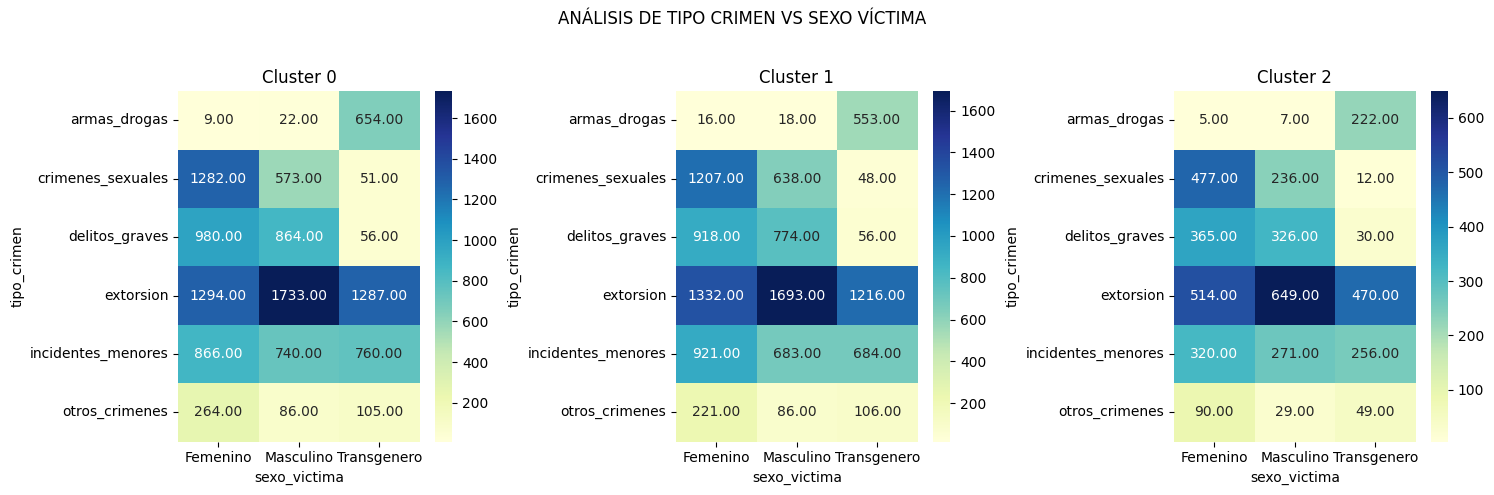

In [ ]:
brooklyn_cluster_pca0 = brooklyn_kmeans_con_reduccion[brooklyn_kmeans_con_reduccion['clusters']==0]
brooklyn_cluster_pca1 = brooklyn_kmeans_con_reduccion[brooklyn_kmeans_con_reduccion['clusters']==1]
brooklyn_cluster_pca2 = brooklyn_kmeans_con_reduccion[brooklyn_kmeans_con_reduccion['clusters']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(brooklyn_cluster_pca0['tipo_crimen'], brooklyn_cluster_pca0['sexo_victima'])
ct1 = pd.crosstab(brooklyn_cluster_pca1['tipo_crimen'], brooklyn_cluster_pca1['sexo_victima'])
ct2 = pd.crosstab(brooklyn_cluster_pca2['tipo_crimen'], brooklyn_cluster_pca2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

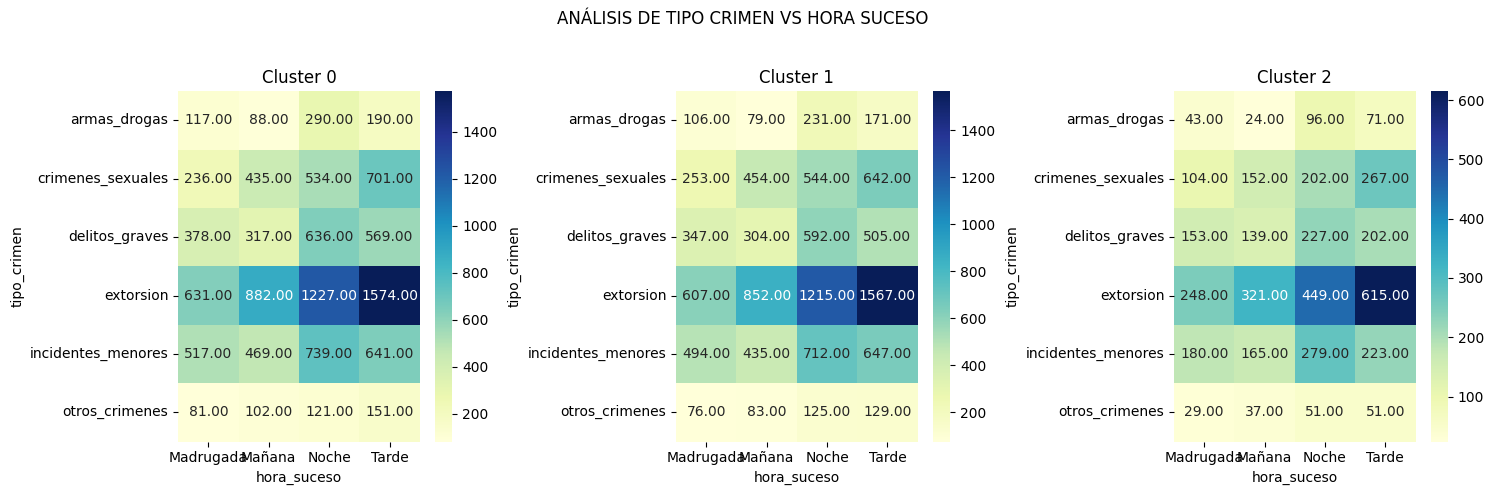

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(brooklyn_cluster_pca0['tipo_crimen'], brooklyn_cluster_pca0['hora_suceso'])
ct1 = pd.crosstab(brooklyn_cluster_pca1['tipo_crimen'], brooklyn_cluster_pca1['hora_suceso'])
ct2 = pd.crosstab(brooklyn_cluster_pca2['tipo_crimen'], brooklyn_cluster_pca2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

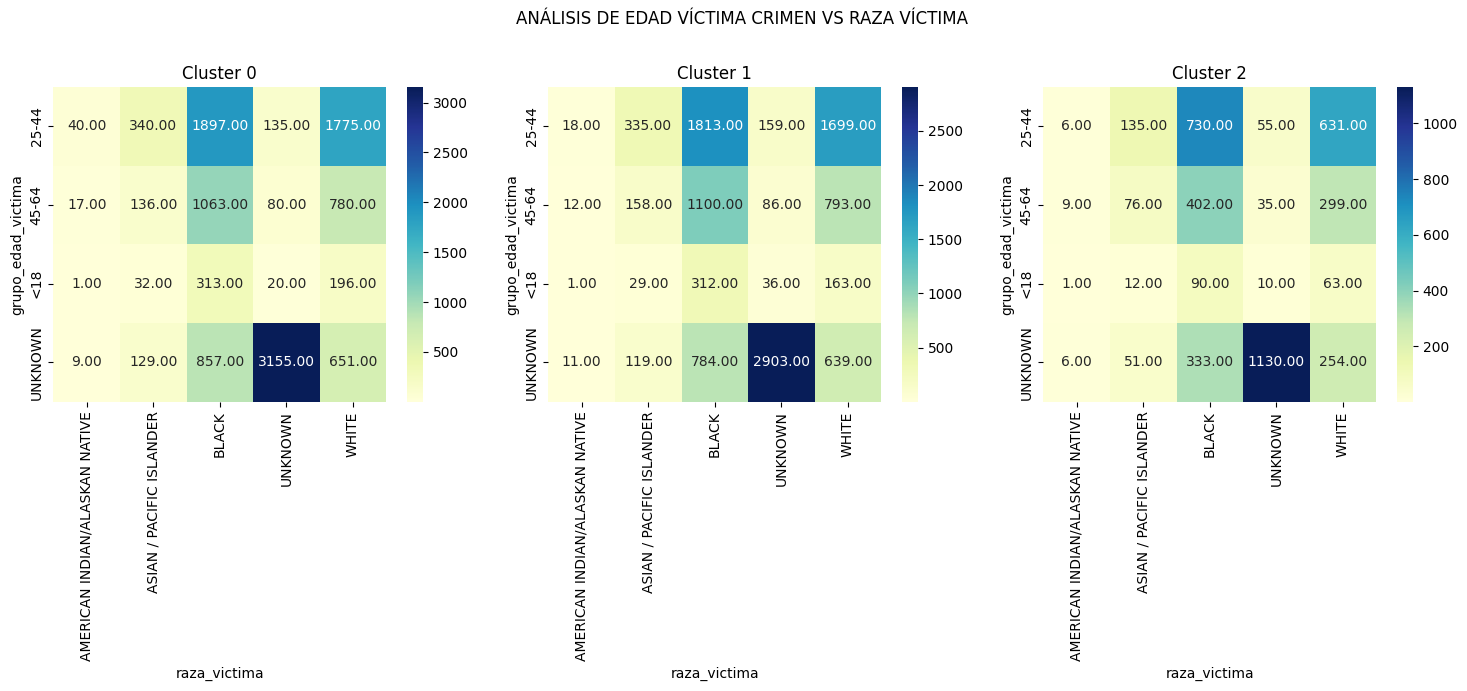

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(brooklyn_cluster_pca0['grupo_edad_victima'], brooklyn_cluster_pca0['raza_victima'])
ct1 = pd.crosstab(brooklyn_cluster_pca1['grupo_edad_victima'], brooklyn_cluster_pca1['raza_victima'])
ct2 = pd.crosstab(brooklyn_cluster_pca2['grupo_edad_victima'], brooklyn_cluster_pca2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

In [ ]:
for column in brooklyn_kmeans_con_reduccion.columns:
  if column not in ['clusters', 'latitud', 'longitud']:
    print(f"Variable {column}:")
    aux1 = brooklyn_kmeans_con_reduccion.groupby(['clusters', column]).size().reset_index().rename(columns = {0:'casos'})
    aux2 = brooklyn_kmeans_con_reduccion.groupby('clusters').size().reset_index().rename(columns = {0:'casos_totales'})
    aux3 = aux1.merge(aux2,how='left', on = 'clusters')
    aux3['participacion'] = aux3['casos']/aux3['casos_totales']
    aux3.drop(columns = ['casos_totales'], inplace = True)
    pd.options.display.float_format = '{:.1%}'.format 
    display(aux3)
    print('\n')
  pd.reset_option('display.float_format')

Variable hora_suceso:


,clusters,hora_suceso,casos,participacion
0,0,Madrugada,1960,16.9%
1,0,Mañana,2293,19.7%
2,0,Noche,3547,30.5%
3,0,Tarde,3826,32.9%
4,1,Madrugada,1883,16.9%
5,1,Mañana,2207,19.8%
6,1,Noche,3419,30.6%
7,1,Tarde,3661,32.8%
8,2,Madrugada,757,17.5%
9,2,Mañana,838,19.4%




Variable jurisdiccion_encargada:


,clusters,jurisdiccion_encargada,casos,participacion
0,0,Externas,1,0.0%
1,0,Otras,73,0.6%
2,0,Policia,10340,88.9%
3,0,Transito,226,1.9%
4,0,Vivienda,986,8.5%
5,1,Otras,71,0.6%
6,1,Policia,9930,88.9%
7,1,Transito,215,1.9%
8,1,Vivienda,954,8.5%
9,2,Externas,1,0.0%




Variable grupo_edad_sospechoso:


,clusters,grupo_edad_sospechoso,casos,participacion
0,0,25-44,2844,24.5%
1,0,45-64,1002,8.6%
2,0,<18,369,3.2%
3,0,UNKNOWN,7411,63.7%
4,1,25-44,2680,24.0%
5,1,45-64,996,8.9%
6,1,<18,361,3.2%
7,1,UNKNOWN,7133,63.9%
8,2,25-44,1043,24.1%
9,2,45-64,425,9.8%




Variable raza_sospechoso:


,clusters,raza_sospechoso,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,19,0.2%
1,0,ASIAN / PACIFIC ISLANDER,231,2.0%
2,0,BLACK,4202,36.1%
3,0,UNKNOWN,5182,44.6%
4,0,WHITE,1992,17.1%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,22,0.2%
6,1,ASIAN / PACIFIC ISLANDER,220,2.0%
7,1,BLACK,4033,36.1%
8,1,UNKNOWN,5022,45.0%
9,1,WHITE,1873,16.8%




Variable sexo_sospechoso:


,clusters,sexo_sospechoso,casos,participacion
0,0,Desconocido,4890,42.1%
1,0,Femenino,1571,13.5%
2,0,Masculino,5165,44.4%
3,1,Desconocido,4715,42.2%
4,1,Femenino,1530,13.7%
5,1,Masculino,4925,44.1%
6,2,Desconocido,1804,41.7%
7,2,Femenino,589,13.6%
8,2,Masculino,1935,44.7%




Variable grupo_edad_victima:


,clusters,grupo_edad_victima,casos,participacion
0,0,25-44,4187,36.0%
1,0,45-64,2076,17.9%
2,0,<18,562,4.8%
3,0,UNKNOWN,4801,41.3%
4,1,25-44,4024,36.0%
5,1,45-64,2149,19.2%
6,1,<18,541,4.8%
7,1,UNKNOWN,4456,39.9%
8,2,25-44,1557,36.0%
9,2,45-64,821,19.0%




Variable raza_victima:


,clusters,raza_victima,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,67,0.6%
1,0,ASIAN / PACIFIC ISLANDER,637,5.5%
2,0,BLACK,4130,35.5%
3,0,UNKNOWN,3390,29.2%
4,0,WHITE,3402,29.3%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,42,0.4%
6,1,ASIAN / PACIFIC ISLANDER,641,5.7%
7,1,BLACK,4009,35.9%
8,1,UNKNOWN,3184,28.5%
9,1,WHITE,3294,29.5%




Variable sexo_victima:


,clusters,sexo_victima,casos,participacion
0,0,Femenino,4695,40.4%
1,0,Masculino,4018,34.6%
2,0,Transgenero,2913,25.1%
3,1,Femenino,4615,41.3%
4,1,Masculino,3892,34.8%
5,1,Transgenero,2663,23.8%
6,2,Femenino,1771,40.9%
7,2,Masculino,1518,35.1%
8,2,Transgenero,1039,24.0%




Variable tipo_crimen:


,clusters,tipo_crimen,casos,participacion
0,0,armas_drogas,685,5.9%
1,0,crimenes_sexuales,1906,16.4%
2,0,delitos_graves,1900,16.3%
3,0,extorsion,4314,37.1%
4,0,incidentes_menores,2366,20.4%
5,0,otros_crimenes,455,3.9%
6,1,armas_drogas,587,5.3%
7,1,crimenes_sexuales,1893,16.9%
8,1,delitos_graves,1748,15.6%
9,1,extorsion,4241,38.0%




Variable lugar:


,clusters,lugar,casos,participacion
0,0,Otros,376,3.2%
1,0,diversion y turismo,1535,13.2%
2,0,lugares publicos,8721,75.0%
3,0,lugares solitarios,434,3.7%
4,0,necesidades diarias,560,4.8%
5,1,Otros,337,3.0%
6,1,diversion y turismo,1539,13.8%
7,1,lugares publicos,8381,75.0%
8,1,lugares solitarios,376,3.4%
9,1,necesidades diarias,537,4.8%




Variable dia_suceso:


,clusters,dia_suceso,casos,participacion
0,0,domingo,1518,13.1%
1,0,jueves,1652,14.2%
2,0,lunes,1672,14.4%
3,0,martes,1629,14.0%
4,0,miercoles,1697,14.6%
5,0,sabado,1684,14.5%
6,0,viernes,1774,15.3%
7,1,domingo,1398,12.5%
8,1,jueves,1603,14.4%
9,1,lunes,1595,14.3%




Variable estacion_suceso:


,clusters,estacion_suceso,casos,participacion
0,0,invierno,2759,23.7%
1,0,otono,2892,24.9%
2,0,primavera,2853,24.5%
3,0,verano,3122,26.9%
4,1,invierno,2588,23.2%
5,1,otono,2793,25.0%
6,1,primavera,2779,24.9%
7,1,verano,3010,26.9%
8,2,invierno,1020,23.6%
9,2,otono,1061,24.5%




Variable mes_suceso:


,clusters,mes_suceso,casos,participacion
0,0,abril,943,8.1%
1,0,agosto,1013,8.7%
2,0,diciembre,1887,16.2%
3,0,febrero,931,8.0%
4,0,julio,1055,9.1%
5,0,junio,983,8.5%
6,0,marzo,912,7.8%
7,0,mayo,927,8.0%
8,0,noviembre,953,8.2%
9,0,octubre,968,8.3%


### **2. Sin reducción de dimensionalidad y aplicación de KModes.**

Se excluyen algunas variables para el análisis

In [ ]:
df_brooklyn_ready.drop(columns = ['jurisdiccion_encargada', 'latitud', 'longitud'], inplace = True)
df_brooklyn_ready_sample.drop(columns = ['jurisdiccion_encargada', 'latitud', 'longitud'], inplace = True)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.


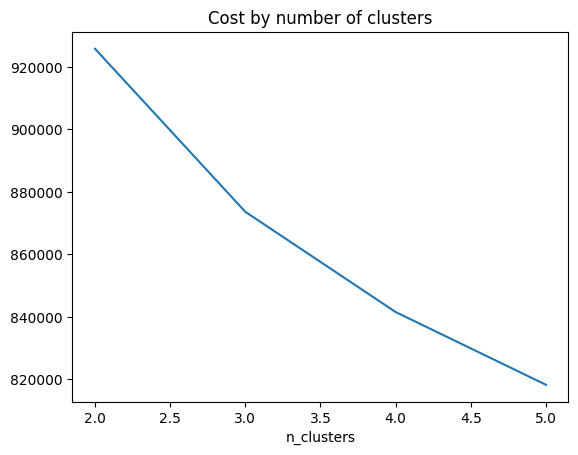

In [ ]:
from kmodes.kmodes import KModes
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_brooklyn = df_brooklyn.copy()
categoricas_brooklyn_encoded = encoder.fit_transform(df_brooklyn)

cost = []
n_clusters = [2,3,4,5]
for k in n_clusters:
  kmodes = KModes(n_clusters=k, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
  kmodes.fit(categoricas_brooklyn_encoded.sample(frac =0.2))
  cost.append(kmodes.cost_)

plt.title('Cost by number of clusters')
plt.xlabel('n_clusters')
plt.plot(n_clusters, cost)
plt.show()

In [ ]:
from kmodes.kmodes import KModes # se puede quitar
from sklearn.preprocessing import OrdinalEncoder # se puede quitar

encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_brooklyn = df_brooklyn.copy()
categoricas_brooklyn_encoded = encoder.fit_transform(df_brooklyn)
metrics_df_general_kmodes = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])

sample = categoricas_brooklyn_encoded.sample(frac =0.5)
n_clusters = [2,3,4,5]
for k in n_clusters:
  kmodes = KModes(n_clusters=k, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
  kmodes.fit(sample)
  labels = kmodes.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(sample, labels)

  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(sample, labels)

  metrics_df = pd.DataFrame({'Metodo': ['KModes'],
                            'k':[k],
                            'Calinski-Harabasz Index': [ch_score],
                            'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general_kmodes = metrics_df_general_kmodes.append(metrics_df, ignore_index=True)

metrics_df_general_kmodes

Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.


,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KModes,2,1021.178904,0.014210
1,KModes,3,827.410884,-0.003920
2,KModes,4,655.639742,-0.017883
3,KModes,5,580.272777,-0.043498


In [ ]:
from kmodes.kmodes import KModes
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_brooklyn = df_brooklyn_ready.copy()
categoricas_brooklyn_encoded = encoder.fit_transform(df_brooklyn_ready)

In [ ]:
kmodes = KModes(n_clusters=3, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
categoricas_brooklyn_encoded2 = categoricas_brooklyn_encoded.copy()
categoricas_brooklyn_encoded2['labels'] = kmodes.fit_predict(categoricas_brooklyn_encoded2)
categoricas_brooklyn['labels']  = categoricas_brooklyn_encoded2['labels'] 
categoricas_brooklyn.head()

Initialization method and algorithm are deterministic. Setting n_init to 1.


,hora_suceso,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso,labels
0,Madrugada,25-44,WHITE,Femenino,UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares publicos,miercoles,otono,diciembre,0
1,Tarde,UNKNOWN,BLACK,Desconocido,<18,BLACK,Masculino,delitos_graves,lugares publicos,martes,invierno,febrero,0
2,Noche,UNKNOWN,UNKNOWN,Desconocido,UNKNOWN,UNKNOWN,Transgenero,incidentes_menores,lugares publicos,miercoles,otono,diciembre,2
3,Tarde,UNKNOWN,WHITE,Femenino,25-44,WHITE,Masculino,incidentes_menores,lugares publicos,martes,verano,agosto,1
4,Madrugada,UNKNOWN,ASIAN / PACIFIC ISLANDER,Masculino,UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares solitarios,domingo,invierno,febrero,0


### Centroides en KModes

In [ ]:
pd.DataFrame(encoder.inverse_transform(kmodes.cluster_centroids_), columns = categoricas_brooklyn_encoded.columns)

,hora_suceso,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso
0,Tarde,UNKNOWN,BLACK,Masculino,UNKNOWN,BLACK,Femenino,extorsion,lugares publicos,jueves,otono,diciembre
1,Noche,UNKNOWN,UNKNOWN,Desconocido,25-44,WHITE,Masculino,extorsion,lugares publicos,viernes,verano,julio
2,Mañana,UNKNOWN,UNKNOWN,Desconocido,UNKNOWN,UNKNOWN,Transgenero,incidentes_menores,lugares publicos,sabado,primavera,junio


### Análisis de clusters en KModes

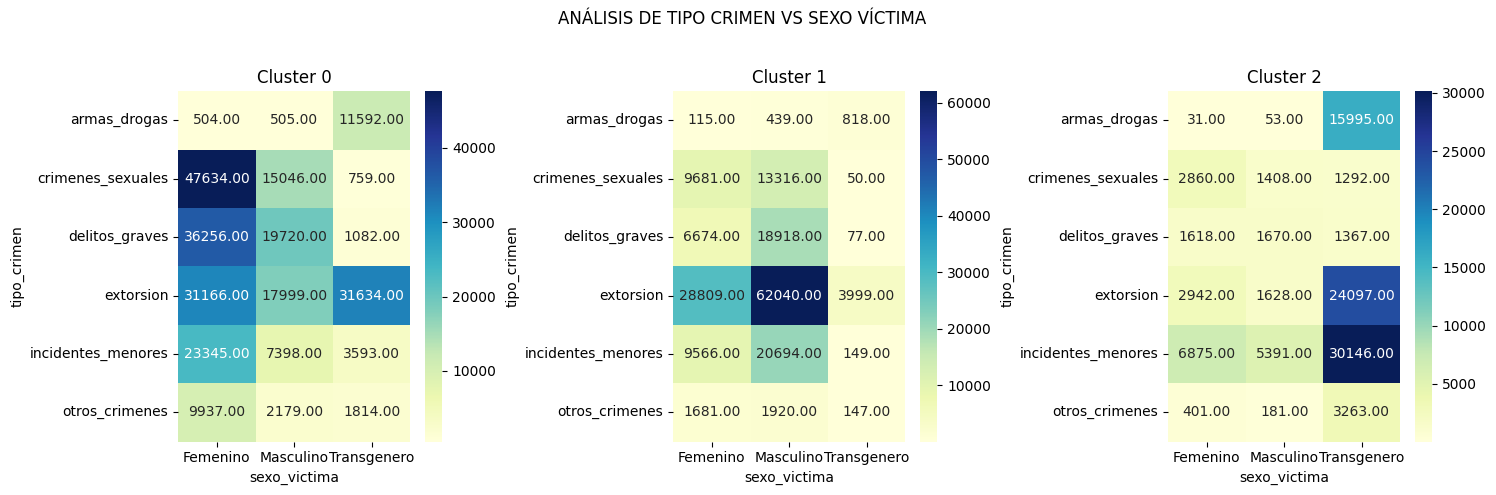

In [ ]:
brooklyn_cluster_kmodes0 = categoricas_brooklyn[categoricas_brooklyn['labels']==0]
brooklyn_cluster_kmodes1 = categoricas_brooklyn[categoricas_brooklyn['labels']==1]
brooklyn_cluster_kmodes2 = categoricas_brooklyn[categoricas_brooklyn['labels']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(brooklyn_cluster_kmodes0['tipo_crimen'], brooklyn_cluster_kmodes0['sexo_victima'])
ct1 = pd.crosstab(brooklyn_cluster_kmodes1['tipo_crimen'], brooklyn_cluster_kmodes1['sexo_victima'])
ct2 = pd.crosstab(brooklyn_cluster_kmodes2['tipo_crimen'], brooklyn_cluster_kmodes2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

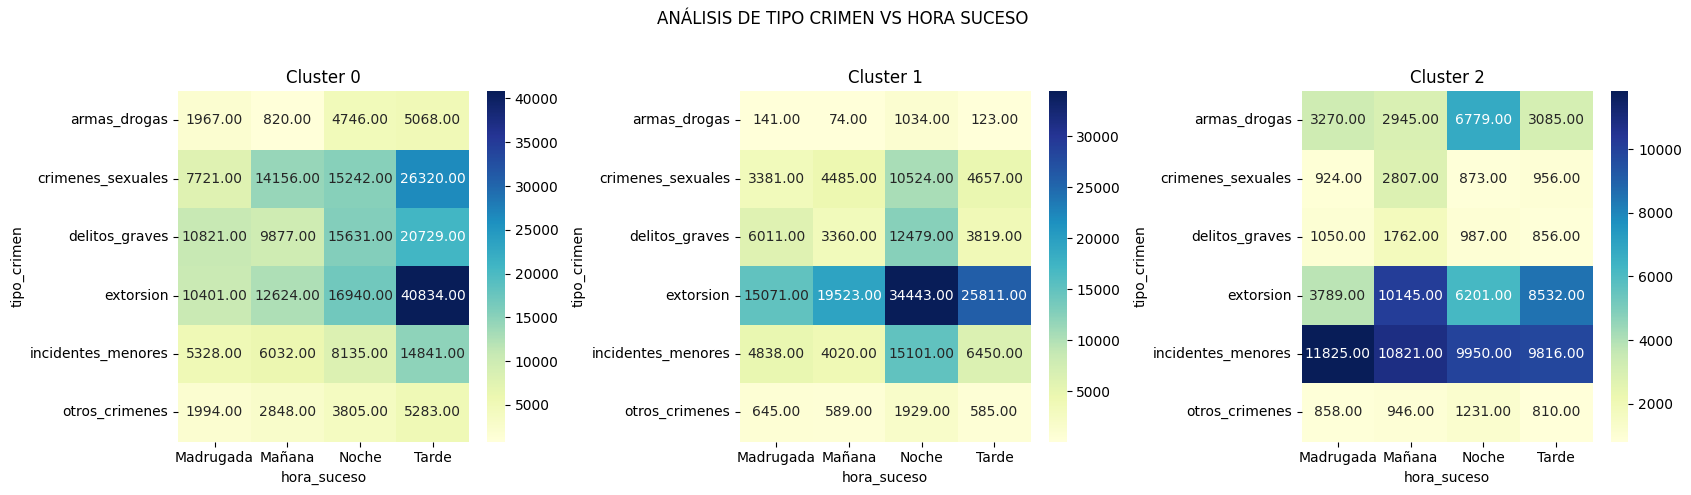

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (17,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(brooklyn_cluster_kmodes0['tipo_crimen'], brooklyn_cluster_kmodes0['hora_suceso'])
ct1 = pd.crosstab(brooklyn_cluster_kmodes1['tipo_crimen'], brooklyn_cluster_kmodes1['hora_suceso'])
ct2 = pd.crosstab(brooklyn_cluster_kmodes2['tipo_crimen'], brooklyn_cluster_kmodes2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

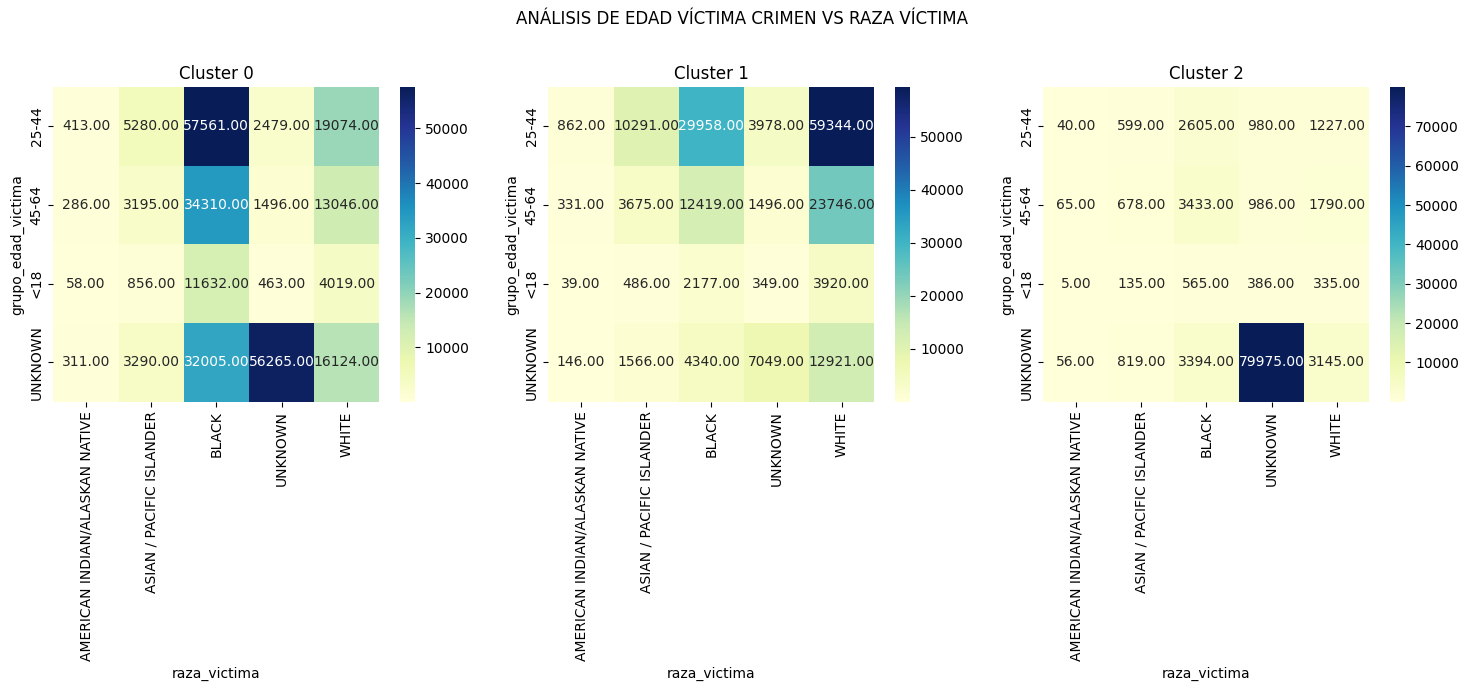

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(brooklyn_cluster_kmodes0['grupo_edad_victima'], brooklyn_cluster_kmodes0['raza_victima'])
ct1 = pd.crosstab(brooklyn_cluster_kmodes1['grupo_edad_victima'], brooklyn_cluster_kmodes1['raza_victima'])
ct2 = pd.crosstab(brooklyn_cluster_kmodes2['grupo_edad_victima'], brooklyn_cluster_kmodes2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

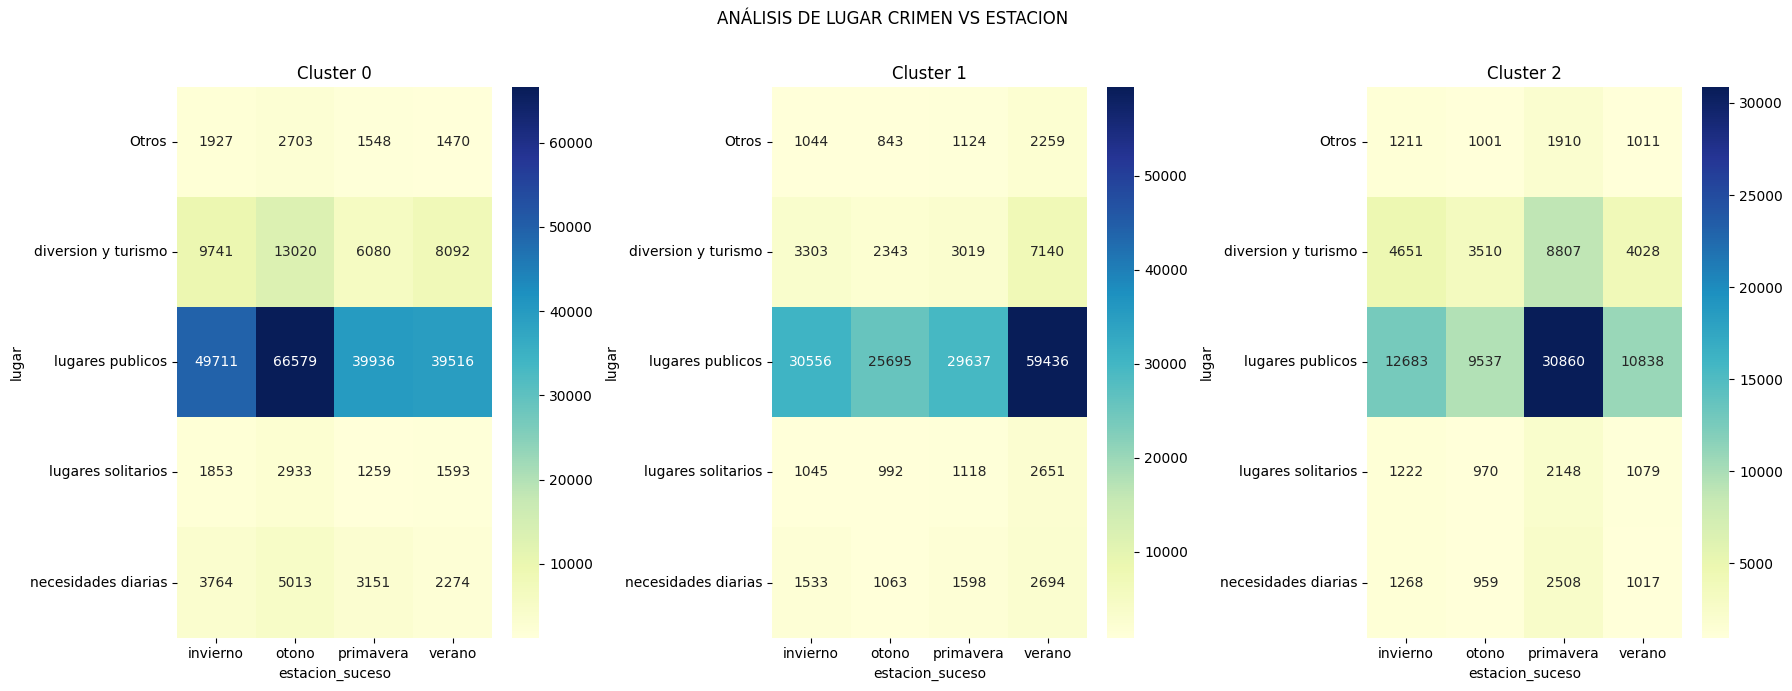

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (18,7))
fig.suptitle('ANÁLISIS DE LUGAR CRIMEN VS ESTACION \n')
ct0 = pd.crosstab(brooklyn_cluster_kmodes0['lugar'], brooklyn_cluster_kmodes0['estacion_suceso'])
ct1 = pd.crosstab(brooklyn_cluster_kmodes1['lugar'], brooklyn_cluster_kmodes1['estacion_suceso'])
ct2 = pd.crosstab(brooklyn_cluster_kmodes2['lugar'], brooklyn_cluster_kmodes2['estacion_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

In [ ]:
for column in categoricas_brooklyn.columns:
  if column not in ['labels', 'latitud', 'longitud']:
    print(f"Variable {column}:")
    aux1 = categoricas_brooklyn.groupby(['labels', column]).size().reset_index().rename(columns = {0:'casos'})
    aux2 = categoricas_brooklyn.groupby('labels').size().reset_index().rename(columns = {0:'casos_totales'})
    aux3 = aux1.merge(aux2,how='left', on = 'labels')
    aux3['participacion'] = aux3['casos']/aux3['casos_totales']
    aux3.drop(columns = ['casos_totales'], inplace = True)
    pd.options.display.float_format = '{:.1%}'.format 
    display(aux3)
    print('\n')
  pd.reset_option('display.float_format')

Variable hora_suceso:


,labels,hora_suceso,casos,participacion
0,0,Madrugada,38232,14.6%
1,0,Mañana,46357,17.7%
2,0,Noche,64499,24.6%
3,0,Tarde,113075,43.1%
4,1,Madrugada,30087,16.8%
5,1,Mañana,32051,17.9%
6,1,Noche,75510,42.2%
7,1,Tarde,41445,23.1%
8,2,Madrugada,21716,21.5%
9,2,Mañana,29426,29.1%




Variable grupo_edad_sospechoso:


,labels,grupo_edad_sospechoso,casos,participacion
0,0,25-44,95118,36.3%
1,0,45-64,35491,13.5%
2,0,<18,12555,4.8%
3,0,UNKNOWN,118999,45.4%
4,1,25-44,21307,11.9%
5,1,45-64,6971,3.9%
6,1,<18,2130,1.2%
7,1,UNKNOWN,148685,83.0%
8,2,25-44,17588,17.4%
9,2,45-64,5692,5.6%




Variable raza_sospechoso:


,labels,raza_sospechoso,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,627,0.2%
1,0,ASIAN / PACIFIC ISLANDER,6300,2.4%
2,0,BLACK,165057,63.0%
3,0,UNKNOWN,39816,15.2%
4,0,WHITE,50363,19.2%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,254,0.1%
6,1,ASIAN / PACIFIC ISLANDER,2486,1.4%
7,1,BLACK,15907,8.9%
8,1,UNKNOWN,133289,74.4%
9,1,WHITE,27157,15.2%




Variable sexo_sospechoso:


,labels,sexo_sospechoso,casos,participacion
0,0,Desconocido,32680,12.5%
1,0,Femenino,49874,19.0%
2,0,Masculino,179609,68.5%
3,1,Desconocido,127936,71.4%
4,1,Femenino,16563,9.2%
5,1,Masculino,34594,19.3%
6,2,Desconocido,64317,63.5%
7,2,Femenino,9276,9.2%
8,2,Masculino,27625,27.3%




Variable grupo_edad_victima:


,labels,grupo_edad_victima,casos,participacion
0,0,25-44,84807,32.3%
1,0,45-64,52333,20.0%
2,0,<18,17028,6.5%
3,0,UNKNOWN,107995,41.2%
4,1,25-44,104433,58.3%
5,1,45-64,41667,23.3%
6,1,<18,6971,3.9%
7,1,UNKNOWN,26022,14.5%
8,2,25-44,5451,5.4%
9,2,45-64,6952,6.9%




Variable raza_victima:


,labels,raza_victima,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,1068,0.4%
1,0,ASIAN / PACIFIC ISLANDER,12621,4.8%
2,0,BLACK,135508,51.7%
3,0,UNKNOWN,60703,23.2%
4,0,WHITE,52263,19.9%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,1378,0.8%
6,1,ASIAN / PACIFIC ISLANDER,16018,8.9%
7,1,BLACK,48894,27.3%
8,1,UNKNOWN,12872,7.2%
9,1,WHITE,99931,55.8%




Variable sexo_victima:


,labels,sexo_victima,casos,participacion
0,0,Femenino,148842,56.8%
1,0,Masculino,62847,24.0%
2,0,Transgenero,50474,19.3%
3,1,Femenino,56526,31.6%
4,1,Masculino,117327,65.5%
5,1,Transgenero,5240,2.9%
6,2,Femenino,14727,14.5%
7,2,Masculino,10331,10.2%
8,2,Transgenero,76160,75.2%




Variable tipo_crimen:


,labels,tipo_crimen,casos,participacion
0,0,armas_drogas,12601,4.8%
1,0,crimenes_sexuales,63439,24.2%
2,0,delitos_graves,57058,21.8%
3,0,extorsion,80799,30.8%
4,0,incidentes_menores,34336,13.1%
5,0,otros_crimenes,13930,5.3%
6,1,armas_drogas,1372,0.8%
7,1,crimenes_sexuales,23047,12.9%
8,1,delitos_graves,25669,14.3%
9,1,extorsion,94848,53.0%




Variable lugar:


,labels,lugar,casos,participacion
0,0,Otros,7648,2.9%
1,0,diversion y turismo,36933,14.1%
2,0,lugares publicos,195742,74.7%
3,0,lugares solitarios,7638,2.9%
4,0,necesidades diarias,14202,5.4%
5,1,Otros,5270,2.9%
6,1,diversion y turismo,15805,8.8%
7,1,lugares publicos,145324,81.1%
8,1,lugares solitarios,5806,3.2%
9,1,necesidades diarias,6888,3.8%




Variable dia_suceso:


,labels,dia_suceso,casos,participacion
0,0,domingo,35419,13.5%
1,0,jueves,48177,18.4%
2,0,lunes,37133,14.2%
3,0,martes,38154,14.6%
4,0,miercoles,38942,14.9%
5,0,sabado,31823,12.1%
6,0,viernes,32515,12.4%
7,1,domingo,24890,13.9%
8,1,jueves,18529,10.3%
9,1,lunes,25369,14.2%




Variable estacion_suceso:


,labels,estacion_suceso,casos,participacion
0,0,invierno,66996,25.6%
1,0,otono,90248,34.4%
2,0,primavera,51974,19.8%
3,0,verano,52945,20.2%
4,1,invierno,37481,20.9%
5,1,otono,30936,17.3%
6,1,primavera,36496,20.4%
7,1,verano,74180,41.4%
8,2,invierno,21035,20.8%
9,2,otono,15977,15.8%




Variable mes_suceso:


,labels,mes_suceso,casos,participacion
0,0,abril,18244,7.0%
1,0,agosto,19435,7.4%
2,0,diciembre,58246,22.2%
3,0,febrero,21422,8.2%
4,0,julio,14019,5.3%
5,0,junio,15827,6.0%
6,0,marzo,19348,7.4%
7,0,mayo,17903,6.8%
8,0,noviembre,29259,11.2%
9,0,octubre,28969,11.0%
